# **Simple DNN 2 - Binary classification, Hyperparameters, Callbacks**  
## **Part 1 Binary classification problem**  
Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. The aim of this lab is to classify movie reviews into “positive” reviews and “negative” reviews, just based on the text content of the reviews.

### **The IMDB dataset**  
We'll be working with the “IMDB dataset”, a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.
Please load the dataset from Keras (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [15]:
from tensorflow.keras.datasets import imdb

# The argument num_words=10000 means that we will only keep the top 10,000 most frequently occurring words 
# in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

### **Preparing the data**  
We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:
- We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape (samples, word_indices), then use as the first layer in our network a layer capable of handling such integer tensors (the Embedding layer, which we will cover in detail later in the book).
- We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as the first layer in our network a Dense layer, capable of handling floating-point vector data.

In [16]:
dimension = 10000

In [17]:
# Implementation of the second solution.
import numpy as np
 
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))  # Create an all-zero matrix of shape (len(sequences), dimension)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
 
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### **Network architecture**  
Based on the previous ex. please implement a deep network architecture shown in the following Figure:  
![network_architecture](images/lesson_2_network_architecture.png)

I propose the following architecture choice:
- Two intermediate layers with 16 hidden units each, and a third layer which will output the scalar prediction regarding the sentiment of the current review.
- The intermediate layers will use relu as their “activation function”, and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target “1”, i.e. how likely the review is to be positive).
- A relu (rectified linear unit) is a function meant to zero-out negative values, while a sigmoid “squashes” arbitrary values into the [0, 1] interval, thus outputting something that can be interpreted as a probability.


In [18]:
import tensorflow as tf
#TODO: Implement the architecture
layers = [
    tf.keras.layers.Dense(16, activation='relu', input_shape=(dimension,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]

### **Network training**  
Since we are facing a binary classification problem and the output of our network is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. It isn't the only viable choice: you could use, for instance, mean_squared_error. But crossentropy is usually the best choice when you are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the “distance” between probability distributions, or in our case, between the ground-truth distribution and our predictions.

To configure the model please use the following parameters:
- rmsprop optimizer
- binary_crossentropy loss function
- accuracy metric

In [19]:
#TODO: Compile the model
model = tf.keras.Sequential(layers)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

### **Validation**  
In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a “validation set” by setting apart 10,000 samples from the original data (suggested split: 25000 train, 10000 validation, 15000 test). You can do it manually or use `train_test_split` from `sklearn` library:

In [20]:
import sklearn
from sklearn.model_selection import train_test_split

test_data_size = 15000
x_data_size = len(x_test)
print(x_data_size)
test_size = test_data_size/x_data_size

#TODO: please divide the dataset according to the description above
x_val, x_test, y_val, y_test = train_test_split(x_test,
                                                y_test,
                                                test_size=test_size,
                                                random_state=42)

# Print the size of the training, validation, and test sets
print("[TRAIN] Data size: %d, Label size: %d" % (len(x_train), len(y_train)))
print("[VALIDATION] Data size: %d, Label size: %d" % (len(x_val), len(y_val)))
print("[TEST] Data size: %d, Label size: %d" % (len(x_test), len(y_test)))

25000
[TRAIN] Data size: 25000, Label size: 25000
[VALIDATION] Data size: 10000, Label size: 10000
[TEST] Data size: 15000, Label size: 15000


Train the model with following parameters:
- x_train, y_train -remained
- epochs - 20
- batch_size - 512
- validation_data=(x_val, y_val)

In [21]:
#TODO: Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20


2023-10-22 20:38:07.687183: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1000000000 exceeds 10% of free system memory.


49/49 [==============================] - 1s 20ms/step - loss: 0.4870 - accuracy: 0.8045 - val_loss: 0.3617 - val_accuracy: 0.8750
Epoch 2/20
49/49 [==============================] - 0s 10ms/step - loss: 0.2850 - accuracy: 0.9004 - val_loss: 0.2974 - val_accuracy: 0.8851
Epoch 3/20
49/49 [==============================] - 0s 10ms/step - loss: 0.2178 - accuracy: 0.9225 - val_loss: 0.2889 - val_accuracy: 0.8862
Epoch 4/20
49/49 [==============================] - 1s 11ms/step - loss: 0.1835 - accuracy: 0.9345 - val_loss: 0.2934 - val_accuracy: 0.8856
Epoch 5/20
49/49 [==============================] - 1s 11ms/step - loss: 0.1592 - accuracy: 0.9425 - val_loss: 0.3410 - val_accuracy: 0.8698
Epoch 6/20
49/49 [==============================] - 1s 11ms/step - loss: 0.1418 - accuracy: 0.9506 - val_loss: 0.3239 - val_accuracy: 0.8791
Epoch 7/20
49/49 [==============================] - 1s 10ms/step - loss: 0.1274 - accuracy: 0.9564 - val_loss: 0.3461 - val_accuracy: 0.8729
Epoch 8/20
49/49 [======

The network should achieve acc: 0.9998 and val_acc: 0.8683.

The history = model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training.  
Let's take a look at it:

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Please use Matplotlib to plot the training and validation loss side by side, as well as the training and validation accuracy.

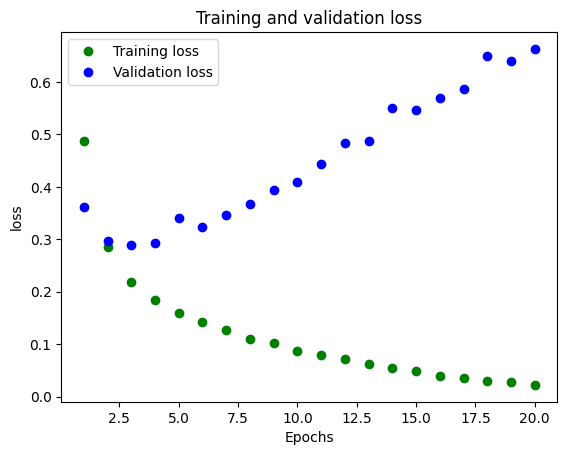

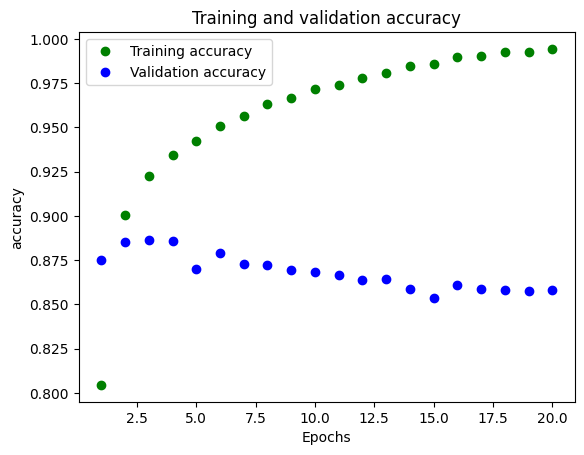

In [23]:
#TODO: plot
import matplotlib.pyplot as plt

def plot_metric(history_dict, metric):
    plt.clf()  # clear figure
    loss_values = history_dict[metric]
    val_loss_values = history_dict[f'val_{metric}']
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'go', label=f'Training {metric}')
    plt.plot(epochs, val_loss_values, 'bo', label=f'Validation {metric}')
    plt.title(f'Training and validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_metric(history_dict, 'loss')
plot_metric(history_dict, 'accuracy')

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. In precise terms, what you are seeing is “overfitting”: after the second epoch, we are over-optimizing on the training data, and we ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.  
Please check how that model performs on the test set too!!

In [24]:
#TODO: evaluate the results on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

 74/469 [===>..........................] - ETA: 0s - loss: 0.6259 - accuracy: 0.8657

2023-10-22 20:38:21.302667: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 600000000 exceeds 10% of free system memory.


469/469 [==============================] - 1s 2ms/step - loss: 0.6223 - accuracy: 0.8582
Test accuracy: 0.8582000136375427
Test loss: 0.6222816109657288


## **Part 2 Hyperparameters**  
As we stated before, there is no ideal solution to each deep learning task. To decide how many layers to add or which activation functions use you need practice and usually a lot of trials and errors. Some people even say that implementing a neural network from scratch is more art than science.

### **Parameter optimisation**
Even then, after you decide what your model will look like, there is a matter of training, which also requires additional parameters. These numbers, that you already encountered, like a number of epochs, learning rate or optimizer are called hyperparameters. Training a neural network is basically an optimization problem, so you can think of setting those parameters as optimizing an optimization. It's not an easy task. There are, however, some tools that can help with that.

### **Callbacks**
One of the simplest methods helpful in parameter selection is using Callbacks. These are basic functions that let you act on the model during training. They allow you to interrupt training to save a model, load a different weight set, or otherwise alter the state of the model. Here are some examples of ways you can use callbacks:
* Model checkpointing—saving the current weights of the model at different points during training.
* Early stopping—interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training).
* Dynamically adjusting the value of certain parameters during training — such as the learning rate of the optimizer.
* Logging training and validation metrics during training, or visualizing the representations learned by the model as they’re updated.

There are many default methods that you can explore in `keras.callbacks` such as `ModelCheckpoint`, `EarlyStopping` or `LearningRateScheduler`. However, one of the most useful things is that you can define your own callback and pass it to the model. So first, check if the desired functionality is available in Keras and if it isn't write it yourself.  

To do so, you can use functions that trigger when certain action occurs:
* `on_epoch_begin`
* `on_epoch_end`
* `on_batch_begin`
* `on_batch_end`
* `on_train_begin`
* `on_train_end`

You can define function behavior after the trigger. In an example below, we check after each epoch if the training accuracy reaches a certain threshold (in this case 90%). If it does, we stop training. This is a useful method to decide on a number of epochs and avoid overfitting. You can read more about callbacks in [Keras Callbacks Documentation](https://keras.io/api/callbacks/).  

First, you need to define a callback class:

In [25]:
import tensorflow as tf
 
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

Then create a callback instance and pass it as an argument when using `.fit()`:

In [26]:
callbacks = myCallback()
 
model.fit(x_train, y_train, epochs=10, callbacks=[callbacks])

Epoch 1/10
 48/782 [>.............................] - ETA: 1s - loss: 0.0197 - accuracy: 0.9935

2023-10-22 20:38:24.552197: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1000000000 exceeds 10% of free system memory.


777/782 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9869
Reached 90% accuracy so cancelling training!
782/782 [==============================] - 2s 2ms/step - loss: 0.0370 - accuracy: 0.9868


### Task
Your **task** is to use it on a mnist classification (lab 1) or imdb (lab 2). You can change parameters or callback behaviour as you wish, as long as it succeeds to stop training earlier.

### **Optimisation algorithms from sklearn**
There are various algorithms that automatically set different parameters, run training, and repeat the process. For example, the `Scikit-Learn` library provides [Grid Search Method](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [Random Search Method](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). You can read more about them in the documentation. More sophisticated methods, like genetic algorithms or particle swarm optimization, are sometimes used too.

Your last task this week is to use `Grid Search Optimisation` algorithm to optimise one of the networks from previous weeks. Choose two parameters (for example number of epochs and batch size) and try two different values for each parameter. `Grid Search` method will therefore create a mesh of these parameters, with four elements (2×2). This process will take more time and computation power, as it will basically train the model four times and compare results. If you don't have a good computer it is best to try it on simple mnist or imdb classification.

In [33]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import models
# alternatively from scikeras.wrappers import KerasClassifier
 
def create_model():
    network = models.Sequential()
    network.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(dimension,)))
    network.add(tf.keras.layers.Dense(16, activation='leaky_relu'))
    network.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    
    network.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
 
    return network
 
model = KerasClassifier(model=create_model)
 
par1_batch = [32, 64]
par2_epoch = [3, 5]
 
param_grid = dict(batch_size=par1_batch,
                  epochs=par2_epoch
                  )
 
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv = 3
                    )
 
grid_results = grid.fit(x_train, y_train)
 
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))

Epoch 1/3
521/521 [==============================] - 2s 3ms/step - loss: 0.3384 - accuracy: 0.8603
Epoch 2/3
521/521 [==============================] - 1s 3ms/step - loss: 0.2029 - accuracy: 0.9234
Epoch 3/3
261/261 [==============================] - 0s 2ms/step
Epoch 1/3
521/521 [==============================] - 3s 4ms/step - loss: 0.3423 - accuracy: 0.8589
Epoch 2/3
521/521 [==============================] - 2s 4ms/step - loss: 0.2039 - accuracy: 0.9238
Epoch 3/3
261/261 [==============================] - 0s 2ms/step
Epoch 1/3
521/521 [==============================] - 2s 3ms/step - loss: 0.3436 - accuracy: 0.8558
Epoch 2/3
521/521 [==============================] - 2s 3ms/step - loss: 0.2052 - accuracy: 0.9214
Epoch 3/3
261/261 [==============================] - 0s 2ms/step
Epoch 1/5
521/521 [==============================] - 2s 3ms/step - loss: 0.3382 - accuracy: 0.8616
Epoch 2/5
521/521 [==============================] - 2s 3ms/step - loss: 0.2053 - accuracy: 0.9236
Epoch 3/5
521

### **Optimisation algorithms from Keras (optional)**
One of the latest trends in Deep Learning (first introduced in 2019) is Keras Autotuner. Basically, it follows the same idea as the Scikit-Learn approach described above (`Grid Search`, `Random Search` or other) but is provided by Keras. If you want, you can try it instead of the above. However, you need to have `keras-tuner` installed, which requires Python 3.6+ and TensorFlow 2.0+. If you cannot install new libraries (because for example it is forbidden on classroom PC), continue with the Scikit-learn approach.
*[Keras Tuner - Documentation](https://keras.io/keras_tuner/)
*[Keras Tuner - Tutorial](https://keras.io/guides/keras_tuner/getting_started/)
*[Keras Tuner - training parameters](https://github.com/keras-team/keras-tuner/issues/122)

Wrap a model inside a function, with optimised parameters as arguments. In the example below we optimise the number of neurons in a Dense layer.

In [37]:
def build_model(hp):
    network = models.Sequential()
    network.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=8, max_value=64, step=8),
                                      activation='relu',
                                      input_shape=(dimension,)))
    network.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
    network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
 
    return network

Set up a Random Search tuner (there are many tuners available) with a model, objective function and max number of iterations. Then run search with all the parameters that you would normally pass to a `fit` function.

In [42]:
import kerastuner

tuner = kerastuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)
 
tuner.search(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 00m 08s]
val_loss: 0.31133365631103516

Best val_loss So Far: 0.2957024574279785
Total elapsed time: 00h 00m 46s
